# Installing Dependencies

In [1]:
!pip install tensorflow==2.12.0rc0 tensorflow-gpu==2.12.0rc0 opencv-python matplotlib

  Using cached tensorflow-2.12.0rc0-cp311-cp311-win_amd64.whl (1.9 kB)


ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==2.12.0rc0 (from versions: 2.12.0)
ERROR: No matching distribution found for tensorflow-gpu==2.12.0rc0

[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install torch


[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import cv2
import os
import tensorflow
import random
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf
import torch

# Limiting GPU usage

In [5]:
gpus=tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memeory_growth(gpu, True)

# Creating Folder paths

In [6]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [7]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

# Load data

In [8]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

In [9]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [10]:
os.listdir('lfw')

['Aaron_Eckhart',
 'Aaron_Guiel',
 'Aaron_Patterson',
 'Aaron_Peirsol',
 'Aaron_Pena',
 'Aaron_Sorkin',
 'Aaron_Tippin',
 'Abbas_Kiarostami',
 'Abba_Eban',
 'Abdel_Aziz_Al-Hakim',
 'Abdel_Madi_Shabneh',
 'Abdel_Nasser_Assidi',
 'Abdoulaye_Wade',
 'Abdulaziz_Kamilov',
 'Abdullah',
 'Abdullah_Ahmad_Badawi',
 'Abdullah_al-Attiyah',
 'Abdullah_Gul',
 'Abdullah_Nasseef',
 'Abdullatif_Sener',
 'Abdul_Majeed_Shobokshi',
 'Abdul_Rahman',
 'Abel_Aguilar',
 'Abel_Pacheco',
 'Abid_Hamid_Mahmud_Al-Tikriti',
 'Abner_Martinez',
 'Abraham_Foxman',
 'Aby_Har-Even',
 'Adam_Ant',
 'Adam_Freier',
 'Adam_Herbert',
 'Adam_Kennedy',
 'Adam_Mair',
 'Adam_Rich',
 'Adam_Sandler',
 'Adam_Scott',
 'Adelina_Avila',
 'Adel_Al-Jubeir',
 'Adisai_Bodharamik',
 'Adolfo_Aguilar_Zinser',
 'Adolfo_Rodriguez_Saa',
 'Adoor_Gopalakarishnan',
 'Adriana_Lima',
 'Adriana_Perez_Navarro',
 'Adrianna_Zuzic',
 'Adrian_Annus',
 'Adrian_Fernandez',
 'Adrian_McPherson',
 'Adrian_Murrell',
 'Adrian_Nastase',
 'Adrien_Brody',
 'Afton_S

# Collecting More Data/ positive and Anchor Classes

In [11]:
# Import uuid library to generate unique image names
import uuid

In [12]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\473a9cb5-b6d4-11ee-8246-b03cdc92d55a.jpg'

In [19]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

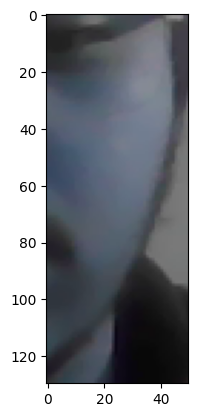

In [20]:
plt.imshow(frame[120:120+250,200:200+250, :])

# Load and Preprocess Images

In [21]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [22]:
dir_test = anchor.as_numpy_iterator()

In [23]:
print(dir_test.next())

b'data\\anchor\\93eb97ff-b54d-11ee-a7b1-b03cdc92d55a.jpg'


# Preproccessing - Scale and Resize

In [24]:
def preprocess(file_path):

    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image
    img = tf.io.decode_jpeg(byte_img)

    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1
    img = img / 255.0

    # Return image
    return img

In [25]:
img = preprocess('data\\anchor\\95e6787d-b54d-11ee-9e76-b03cdc92d55a.jpg')
img.numpy().max()

0.80490196

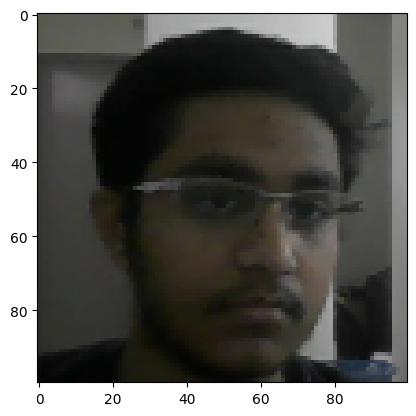

In [26]:
plt.imshow(img)

In [27]:
dataset.map(preprocess)

NameError: name 'dataset' is not defined

# Creating a labelled Dataset

In [28]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [29]:
data

<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [30]:
samples = data.as_numpy_iterator()

In [31]:
example = samples.next()

In [32]:
example

(b'data\\anchor\\967d5e14-b54d-11ee-bdea-b03cdc92d55a.jpg',
 b'data\\positive\\c1b0ef82-b54d-11ee-b227-b03cdc92d55a.jpg',
 1.0)

# Building Train and Test partition

In [33]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [34]:
res = preprocess_twin(*example)

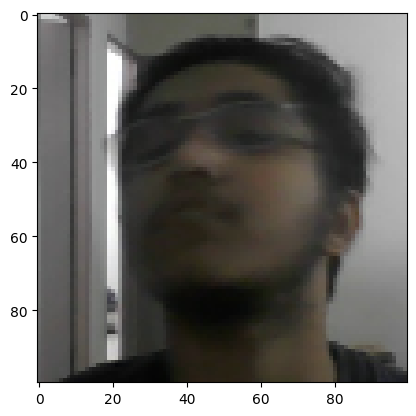

In [35]:
plt.imshow(res[1])

In [36]:
res[2]

1.0

In [37]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [38]:
data

<_ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [39]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [40]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [41]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [42]:
test_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

# Model Engineering

In [43]:
#Building embedding Layer
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [44]:
embedding = make_embedding()

In [45]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [46]:
#Building Distance layer
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding) 

In [47]:
l1 = L1Dist()

In [48]:
l1(anchor_embedding, validation_embedding)

NameError: name 'anchor_embedding' is not defined

In [49]:
# Making Simaese Model

In [50]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [51]:
siamese_model = make_siamese_model()

In [52]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

# Training

In [53]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [54]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [55]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [59]:
@tf.function #compiles function into callable tensorflow graph
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

In [60]:
## Building Training Loop

In [61]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [62]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [63]:
## Training the model

In [64]:
EPOCHS = 60

In [65]:
train(train_data, EPOCHS)


 Epoch 1/60
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
10/10 [==============================] - 119s 12s/step
0.18080579 0.20588236 1.0

 Epoch 2/60
10/10 [==============================] - 115s 11s/step
0.07251597 0.54285717 1.0

 Epoch 3/60
10/10 [==============================] - 116s 12s/step
0.036948886 1.0 1.0

 Epoch 4/60
10/10 [==============================] - 116s 12s/step
0.017056266 1.0 1.0

 Epoch 5/60
10/10 [==============================] - 117s 12s/step
0.0006123474 1.0 1.0

 Epoch 6/60
10/10 [==============================] - 118s 12s/step
0.0021248912 1.0 1.0

 Epoch 7/60
10/10 [==============================] - 116s 12s/step
0.026987744 1.0 1.0

 Epoch 8/60
10/10 [==============================] - 114s 11s/step
0.0012314032 1.0 1.0

 Epoch 9/60
10/10 [==============================] - 117s 12s/step
0.00055616605 1.0 1.0

 Epoch 10/60
10/10 [================

# Evaluvation

In [66]:
from tensorflow.keras.metrics import Precision, Recall

In [67]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [68]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 [==============================] - 1s 528ms/step


In [69]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]

In [70]:
y_true

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
      dtype=float32)

In [71]:
## Calculating Metrics

In [72]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [73]:
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [74]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 0s 252ms/step
1.0 1.0


# Saving the model

In [75]:
# Save weights
siamese_model.save('siamesemodelv2.h5')

C:\Users\modip\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [76]:
L1Dist

__main__.L1Dist

In [77]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [78]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

1/1 [==============================] - 0s 295ms/step


array([[9.9999970e-01],
       [6.7965669e-07],
       [1.2396805e-05],
       [3.3948572e-06]], dtype=float32)

In [79]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [80]:
## Real-Time Testing

In [94]:
application_data\verification_images

SyntaxError: unexpected character after line continuation character (2818603333.py, line 1)

In [95]:
os.listdir(os.path.join('application_data', 'verification_images'))

['b8ea326b-b54d-11ee-9567-b03cdc92d55a.jpg',
 'bb521471-b54d-11ee-b339-b03cdc92d55a.jpg',
 'bb7f8132-b54d-11ee-b307-b03cdc92d55a.jpg',
 'bba7a376-b54d-11ee-bbdf-b03cdc92d55a.jpg',
 'bbf870b1-b54d-11ee-9ad6-b03cdc92d55a.jpg',
 'bc30f78f-b54d-11ee-9117-b03cdc92d55a.jpg',
 'bc37f7b1-b54d-11ee-99ea-b03cdc92d55a.jpg',
 'bcf7b39a-b54d-11ee-b4dd-b03cdc92d55a.jpg',
 'bd0cdaa2-b54d-11ee-bbe0-b03cdc92d55a.jpg',
 'bdb26018-b54d-11ee-9273-b03cdc92d55a.jpg',
 'be02c4ee-b54d-11ee-a427-b03cdc92d55a.jpg',
 'bebbcc92-b54d-11ee-ad03-b03cdc92d55a.jpg',
 'befc3528-b54d-11ee-9470-b03cdc92d55a.jpg',
 'c1b0ef82-b54d-11ee-b227-b03cdc92d55a.jpg',
 'c1b82c22-b54d-11ee-a2f0-b03cdc92d55a.jpg',
 'c23d8731-b54d-11ee-971d-b03cdc92d55a.jpg',
 'c2449b87-b54d-11ee-8350-b03cdc92d55a.jpg',
 'c263557d-b54d-11ee-9fc8-b03cdc92d55a.jpg',
 'c28bc920-b54d-11ee-96d0-b03cdc92d55a.jpg',
 'c2b442b8-b54d-11ee-bf74-b03cdc92d55a.jpg',
 'c304a66d-b54d-11ee-b95f-b03cdc92d55a.jpg',
 'c36f2470-b54d-11ee-8617-b03cdc92d55a.jpg',
 'c3a0be8b

In [96]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [97]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\b8ea326b-b54d-11ee-9567-b03cdc92d55a.jpg
application_data\verification_images\bb521471-b54d-11ee-b339-b03cdc92d55a.jpg
application_data\verification_images\bb7f8132-b54d-11ee-b307-b03cdc92d55a.jpg
application_data\verification_images\bba7a376-b54d-11ee-bbdf-b03cdc92d55a.jpg
application_data\verification_images\bbf870b1-b54d-11ee-9ad6-b03cdc92d55a.jpg
application_data\verification_images\bc30f78f-b54d-11ee-9117-b03cdc92d55a.jpg
application_data\verification_images\bc37f7b1-b54d-11ee-99ea-b03cdc92d55a.jpg
application_data\verification_images\bcf7b39a-b54d-11ee-b4dd-b03cdc92d55a.jpg
application_data\verification_images\bd0cdaa2-b54d-11ee-bbe0-b03cdc92d55a.jpg
application_data\verification_images\bdb26018-b54d-11ee-9273-b03cdc92d55a.jpg
application_data\verification_images\be02c4ee-b54d-11ee-a427-b03cdc92d55a.jpg
application_data\verification_images\bebbcc92-b54d-11ee-ad03-b03cdc92d55a.jpg
application_data\verification_images\befc3528-b54d-11ee-9470-b03

In [98]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [99]:
## opencv realtime verification

In [129]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10
        
#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.6)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 149ms/step
True


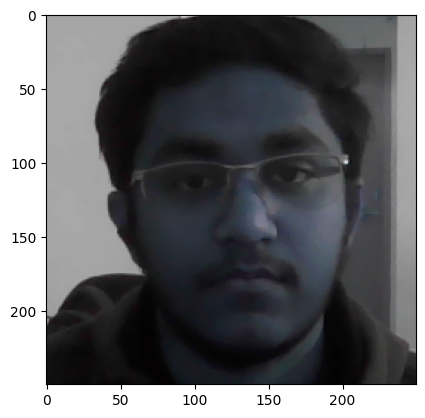

In [130]:
plt.imshow(frame)

In [131]:
np.sum(np.squeeze(results) > 0.9)

17

In [132]:
results

[array([[0.707972]], dtype=float32),
 array([[0.817418]], dtype=float32),
 array([[0.76942724]], dtype=float32),
 array([[0.6902916]], dtype=float32),
 array([[0.5809289]], dtype=float32),
 array([[0.9262646]], dtype=float32),
 array([[0.9262646]], dtype=float32),
 array([[0.8091741]], dtype=float32),
 array([[0.78360504]], dtype=float32),
 array([[0.9900755]], dtype=float32),
 array([[0.05555334]], dtype=float32),
 array([[0.31959423]], dtype=float32),
 array([[0.9986794]], dtype=float32),
 array([[0.8604648]], dtype=float32),
 array([[0.9843476]], dtype=float32),
 array([[0.9707131]], dtype=float32),
 array([[0.9707131]], dtype=float32),
 array([[0.9841031]], dtype=float32),
 array([[0.9270156]], dtype=float32),
 array([[0.91804075]], dtype=float32),
 array([[0.99485224]], dtype=float32),
 array([[0.66725725]], dtype=float32),
 array([[0.4760183]], dtype=float32),
 array([[0.46868917]], dtype=float32),
 array([[0.4178102]], dtype=float32),
 array([[0.4625644]], dtype=float32),
 array